# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import patsy

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [3]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [4]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [5]:
current_event = 30
element_types = [1, 2, 3]
threshold_minutes = 85

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

# Models

## Bernoulli teams model

### Preparing data

In [7]:
btm_df = element_gameweek_df.copy()

In [8]:
btm_formula = 'clean_sheets ~ C(opposition_team) + C(own_team)'

btm_response_df, btm_explanatory_df = patsy.dmatrices(btm_formula, btm_df, return_type='dataframe')

### Fitting model

In [9]:
btm_results = sm.GLM(
    btm_response_df,
    btm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [10]:
print(btm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           clean_sheets   No. Observations:                 4679
Model:                            GLM   Df Residuals:                     4640
Model Family:                Binomial   Df Model:                           38
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2415.9
Date:                Sat, 23 Mar 2019   Deviance:                       4831.9
Time:                        16:16:17   Pearson chi2:                 4.58e+03
No. Iterations:                     6                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -3.2657      0.315    -10.379      0.000      -3.882      -2.649
C(oppositi

### Model fit

In [11]:
btm_results.aic

4909.8630659272685

In [12]:
btm_results.bic

-34380.03309969197

In [13]:
btm_pearson_results = goodness_fit.pearson_chi_squared_test(btm_results)
btm_pearson_results

(False, 0.719711263818926)

In [14]:
btm_results.resid_deviance.describe()

count    4679.000000
mean       -0.117461
std         1.009500
min        -1.741573
25%        -0.823353
50%        -0.531882
75%         0.990704
max         2.631436
dtype: float64

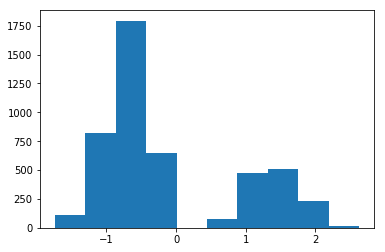

In [15]:
plt.figure()
plt.hist(btm_results.resid_deviance)
plt.show()

## Bernoulli players model

### Preparing data

In [16]:
bpm_df = element_gameweek_df.copy()

In [17]:
bpm_formula = 'clean_sheets ~ C(opposition_team) + C(element)'

bpm_response_df, bpm_explanatory_df = patsy.dmatrices(bpm_formula, bpm_df, return_type='dataframe')

### Fitting model

In [18]:
bpm_results = sm.GLM(
    bpm_response_df,
    bpm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [19]:
print(bpm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           clean_sheets   No. Observations:                 4679
Model:                            GLM   Df Residuals:                     4296
Model Family:                Binomial   Df Model:                          382
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2307.3
Date:                Sat, 23 Mar 2019   Deviance:                       4614.6
Time:                        16:16:26   Pearson chi2:                 4.52e+03
No. Iterations:                    24                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -3.6603      1.154     -3.171      0.002      -5.923      -1.398
C(oppositi

### Model fit

In [20]:
bpm_results.aic

5380.6430145319255

In [21]:
bpm_results.bic

-31690.164297429343

In [22]:
bpm_pearson_results = goodness_fit.pearson_chi_squared_test(bpm_results)
bpm_pearson_results

(True, 0.00869395244661253)

In [23]:
bpm_results.resid_deviance.describe()

count    4679.000000
mean       -0.105858
std         0.987546
min        -1.915844
25%        -0.805566
50%        -0.492220
75%         0.885616
max         3.028835
dtype: float64

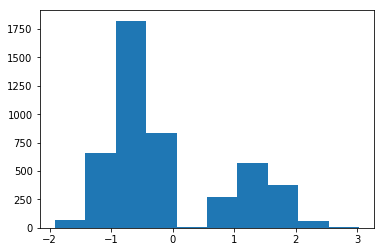

In [24]:
plt.figure()
plt.hist(bpm_results.resid_deviance)
plt.show()

# Model comparison

In [25]:
{
    'Bernoulli teams': btm_results.aic,
    'Bernoulli players': bpm_results.aic,
}

{'Bernoulli teams': 4909.8630659272685,
 'Bernoulli players': 5380.6430145319255}

AIC prefers teams model

In [26]:
{
    'Bernoulli teams': btm_results.bic,
    'Bernoulli players': bpm_results.bic,
}

{'Bernoulli teams': -34380.03309969197,
 'Bernoulli players': -31690.164297429343}

BIC prefers teams model

In [27]:
{
    'Bernoulli teams': btm_pearson_results,
    'Bernoulli players': bpm_pearson_results,
}

{'Bernoulli teams': (False, 0.719711263818926),
 'Bernoulli players': (True, 0.00869395244661253)}

Teams model fits